In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : PsKDnKNn 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 543678.62
  Predicted background counts     : 533641.14
  Predicted excess counts         : 10037.49

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2297944.15

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal m

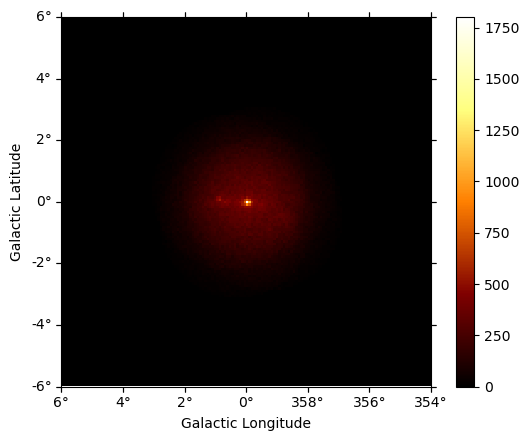

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
#models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_best_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_standard.models[0].parameters['lon_0'].frozen = True
dataset_standard.models[0].parameters['lat_0'].frozen = True
dataset_standard.models[1].parameters['lon_0'].frozen = True
dataset_standard.models[1].parameters['lat_0'].frozen = True
#dataset_standard.models[2].parameters['lon_0'].frozen = True
#dataset_standard.models[2].parameters['lat_0'].frozen = True

#create asimov dataset
dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


#Input Model for Comparison
dataset_input = dataset_standard.copy()
models_input = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models_input.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_input.name)
bkg_model.parameters['tilt'].frozen  = False
models_input.append(bkg_model)
dataset_input.models = models

#set mask to exclude J1745
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_asimov.mask_fit = mask_space

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [6]:
shift = 0.10 #+0.085
tilt = 0.015

N = 100 #831
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True

In [7]:
%%time
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        #print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.backend = "minuit"
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'lambda_', 'norm', 'tilt']:
            if p in ['norm', 'tilt']:
                stri += str(dataset.background_model.parameters[p].value)  + '   ' +  str(dataset.background_model.parameters[p].error)  + '   '
            else:
                stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        #print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass

0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.033116371202724 0.06060839774913009
norm 0.9776019484426567 0.05270692833274617
norm 1.0126985861510924 0.051685291863714775
norm 0.9694763509782444 0.0516764569130126
norm 1.077401859249815 0.05661775356992897
norm 0.9405784614284296 0.058532480921033136
norm 0.9351507787479398 0.06481958916336417
norm 1.0144928703764822 0.07530142257294513
norm 0.8579272572468999 0.08289246366150006
norm 1.2657617135377681 0.11722585639968473
norm 1.07931821613916 0.14130965982461172
norm 1.3075596939353262 0.19411797761709979
norm 0.6411225532407695 0.20139171784007265
norm 0.49980935074780436 0.25641055921315864
norm 0.8575438559471888 0.49470938941642706
norm 1.4512720595394766 0.973842355400462
norm -0.6542249133167684 0.1555890566266975
norm 3.8178026648554946 7.530307141461942
norm 48.157029792509206 45.93569634891015
norm -27938.530449236434 35084.71080379458
1
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0609028225474022 0.06163603694

norm -159.64090045094426 124.27919703421311
9
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0080222189532653 0.06227794678941518
norm 0.9894990727158495 0.054371721981608674
norm 0.9564394318068131 0.05238313892205862
norm 1.0484077360011015 0.05425369845972424
norm 1.021131101958031 0.05680817597639293
norm 1.0010185872218564 0.05959137013828616
norm 0.9051840898074559 0.0644785573483661
norm 1.0923704760679622 0.07798628577227269
norm 1.017321627136032 0.08790093312114194
norm 1.026217550221412 0.10534478992709904
norm 0.9434260575461689 0.12773382191028523
norm 0.8911030142866571 0.14840397513948433
norm 1.0879525042327212 0.20622278380522058
norm 0.7390943603181614 0.23409742116525944
norm 1.0397009886803479 0.40998958425903637
norm 1.709648577364359 0.7296641746955925
norm 0.8982281722088862 0.9164224181921444
norm 2.4505694817440085 2.821967077085124
norm -55.27879138193298 25.990187101269008
norm 34.32265531434365 62.30636144038813
10
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1

norm 2.501568242222742 8.31966462846812
norm -58.9965824835872 97.54111240681107
18
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9740542669218492 0.06612765190663267
norm 1.0545751748587893 0.057678035773168754
norm 0.9867356239140949 0.05421441866893393
norm 0.9806068798141924 0.05339297115330741
norm 1.0004645607646183 0.05641049220120338
norm 1.0080450596698198 0.060667381516250445
norm 0.9884427159504209 0.06563763329535083
norm 0.9519869832693755 0.07318562107876517
norm 0.9487763636266702 0.08363783582851195
norm 1.1807532103813398 0.10957152545035088
norm 1.0496530273112425 0.13085606098260608
norm 1.0446167596519724 0.16616233679517362
norm 0.6832929581407792 0.18440108109692283
norm 1.1663293874182667 0.3389330727985176
norm 1.2036213060093417 0.4924112585035252
norm -0.40500324254249936 0.6271459598536967
norm 0.9439432691936953 2.2470356992158695
norm 6.06230875199364 6.671741324193629
norm 63.72250977008455 45.582251483919855
norm -133.3440584177425 54.52538453661537


norm -0.8108226091640789 0.2071712842970936
norm -5.358324654513147 35.49361100075176
norm -122.77029560074828 136.4259176328855
27
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9761100887651443 0.06135419690518492
norm 1.1724954154990308 0.05694614836288575
norm 0.8713287167562624 0.05151183447399272
norm 0.9012324359194448 0.052687957799550725
norm 1.0113417833811473 0.05845972112430905
norm 1.0855615072965876 0.06432470479555352
norm 0.9799615992461433 0.07006697107766989
norm 1.0273771048734557 0.0807232610710419
norm 0.9981865563067865 0.09250873885173128
norm 1.0163702425882815 0.11514379915263162
norm 1.0072339632443272 0.14047523615100685
norm 0.9582985026188721 0.16741313275053213
norm 0.9370453317731183 0.21479647766727558
norm 1.3424715311582798 0.33545477228346043
norm 0.4488800865496974 0.30853969713582347
norm 1.9699366147604607 0.8689290996056861
norm 0.39139503453250113 0.7138090294225775
norm -0.6041474938231612 0.14445891141442813
norm -9.210428611172997 3.415695

norm -0.4499158760581041 1.9040784498069845
norm -48.99489607058217 18.27511085050442
norm 23.59474824653607 24.499403445317572
norm -104.80246793439647 45.18927790776833
36
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0281248110417516 0.06530010363519712
norm 1.0205552669777784 0.05715791106786798
norm 0.9146680503349514 0.05342828641738317
norm 1.0529474573101676 0.0556078060069325
norm 1.0031199625688825 0.05694317930510906
norm 0.9302852988166415 0.05937902150074332
norm 1.0246223323078325 0.0681997501764995
norm 1.087640441495852 0.07954796051421746
norm 1.0735924990912482 0.09160672383523873
norm 0.7949615246589687 0.09900829492439017
norm 0.9399638809281065 0.1324326473131691
norm 1.2648538841578685 0.1850038518804017
norm 0.8837054762097899 0.20769777166807243
norm 0.9229954443797037 0.3176678891843547
norm 1.2262733066557772 0.5453239701497883
norm 0.14836697912335525 0.8193229880110184
norm 2.5776630760683394 2.2434524589281137
norm -21.223679941590266 5.315003774986319

norm 1.3810256693132468 0.6096585104421655
norm 0.6288210985299463 0.7041117847964219
norm -0.37949946482645464 0.08225531434516034
norm -2.673393087842174 1.0639649911830018
norm -18.21918487312282 9.210107858114656
45
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9689187648506238 0.06075292230360438
norm 0.9607264641328744 0.054051730716176645
norm 1.1092272660614904 0.05476612179927848
norm 1.020028866619602 0.05459005086575853
norm 0.9522895171175106 0.056354205864719564
norm 0.9137097927667057 0.060089799229537985
norm 1.010540645201567 0.06890031561563786
norm 1.0584609932665396 0.08004092378274771
norm 1.0143392506661169 0.09005695920644488
norm 1.0169404753451303 0.10635457340485854
norm 0.9257315356089655 0.12725311006659906
norm 0.9810992932203131 0.15839879805413953
norm 1.0591080065332155 0.20307876470143696
norm 0.9793360901441649 0.25968371156079917
norm 1.0053336422700727 0.3358943797486572
norm 1.6088408498805806 0.6428006576639992
norm 0.7155904042043285 0.7241214

norm 0.6584948275775598 0.3474456212750439
norm 0.9903894077308167 0.6008435746482662
norm 1.4967668671273335 1.126857002224526
norm 1.9409827182514359 2.244526877496772
norm 4.074145219918721 6.744615799088096
norm 26.82178829798492 41.34161993829941
54
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0415541083816517 0.06360301379175581
norm 1.0103839589244867 0.054875926197957337
norm 0.9977415255826506 0.05291932898395016
norm 0.9226912772114447 0.05090170724741142
norm 1.0028361101006797 0.05479374409141098
norm 1.0414256779006312 0.059636979682451755
norm 1.0356511906102879 0.06639841215801479
norm 0.8938839024200295 0.07107371492080564
norm 1.080711424081664 0.08871325841381313
norm 1.0466964389516806 0.10825047668716109
norm 0.9471686131669046 0.13235480378411588
norm 1.1655928660971708 0.19270863472797967
norm 0.8432006313445124 0.23177448160366637
norm 0.8846801808198552 0.3489106543418679
norm 0.9076474975465663 0.5816389160208443
norm 0.4039187934694819 0.8261822723530435

norm 1.0056115075113046 0.2935895066761219
norm 0.7534821008824633 0.3565733525640686
norm 0.6752286691774023 0.5078865413164076
norm 0.1838042214519011 0.7709114333827309
norm 3.4135740220335458 3.091514256463828
norm -78.32020594724645 115.39743459141307
norm 87.62806097847023 77.04860865074734
63
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0349867978329914 0.06527862000233589
norm 0.9226031676954084 0.05420382854965587
norm 1.0021702197175548 0.05323057474597997
norm 0.9927167997016535 0.05309769535320331
norm 1.0392225904537402 0.05657758532198071
norm 1.0544410317547508 0.060138828863040526
norm 1.0091535669905434 0.06576284687841956
norm 0.986140393173177 0.07344200242109736
norm 1.0401943831676819 0.0849461199038282
norm 0.9038845955937276 0.09664749019391601
norm 0.9133708254784415 0.11499353917830732
norm 1.0456094426289713 0.15522689220649324
norm 0.9214885686088834 0.18288852299314126
norm 0.9445129965730279 0.2580094217694783
norm 0.7167922829329963 0.324644730359828

norm 1.4104364773101563 0.31107854743548047
norm 1.0631502928947665 0.3965316761138235
norm -0.18346451086403184 0.01815862678728083
norm -0.2811876964030277 0.040315362997643434
norm 1.2585755499784101 2.156703369912407
norm -10.061720934014657 3.8560180048431962
norm 7.929014673365328 39.43669118013881
72
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9951228027810598 0.06298795362460774
norm 1.0052944168747997 0.055581555572277314
norm 0.9719542377120586 0.05355196952264118
norm 1.0247791371515587 0.054436035002798366
norm 1.0160301195075094 0.05795261940359642
norm 1.0065860809463707 0.06123470270725198
norm 0.9721626034744042 0.06757461464289843
norm 1.0253558729946628 0.07829608524169065
norm 0.941708490986127 0.0870478954854977
norm 1.0493157748036592 0.10884834863151874
norm 0.8862125465775714 0.1272777546808114
norm 1.1450534459529218 0.17379534096874655
norm 1.0289737063949487 0.21330729824471711
norm 0.7045391714230994 0.2595599133812644
norm 1.2199585358423501 0.4309337

norm 1.2621034902393529 0.2339403850986124
norm 1.4775527763305252 0.34064300468597536
norm 0.8635306583393955 0.3894234772292368
norm 0.1926505628506247 0.3719739753285255
norm 1.1911580558523966 1.3405330713487287
norm 0.5272302220881426 1.6557663256430748
norm -7.946346396285325 2.3159620073439586
norm -77.57284564985372 110.10857399518675
81
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.971609817054447 0.06419371000968935
norm 1.0201423906489056 0.05670772989502391
norm 1.0426727802678377 0.05497426829752281
norm 0.9714247647492674 0.054308574458902865
norm 0.8846590668511743 0.05513377070708227
norm 1.0898050282465261 0.06293138338911645
norm 1.052405015943114 0.06941629681060552
norm 1.102122261957144 0.07980470963171053
norm 0.8562773899450952 0.08364902658851806
norm 0.8430307506121009 0.09920387812272816
norm 1.1288098562292743 0.14026347314335177
norm 1.09931397460201 0.1702899994294439
norm 1.0300155334276027 0.21369016972202995
norm 0.900589934673852 0.2837048819339378

norm 1.027564607895572 0.17065381233457008
norm 0.8324136066269736 0.20918866554494
norm 1.572508194167125 0.3817813917758209
norm 0.8329259751763745 0.4313334314038142
norm 0.5930658591024442 0.6796227860745971
norm 1.2353769407808204 1.7394156433587635
norm -2.5071444001128897 0.9744613574584685
norm -34.336708683952864 17.15241132386848
norm -5358.819312904941 3199.6483713194507
90
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0021667866831923 0.058690929644502586
norm 0.9427867399846597 0.0514066410706916
norm 1.0832082584417668 0.05249913794533554
norm 0.9970624049364727 0.05214062882516239
norm 0.9922331548513278 0.05602245539500605
norm 0.9539065290157474 0.05953476572514559
norm 1.006285920471777 0.06836442563023683
norm 0.9727672860225681 0.0762439782669577
norm 1.0620939463743202 0.09227612877542862
norm 1.010045254159747 0.1097586866250547
norm 0.9294787936169544 0.13407082346410848
norm 1.0534702000123461 0.17649132336370363
norm 1.171299591348973 0.2418134739110813
no

norm 0.9605688661356477 0.13371477099061396
norm 0.9809939697330726 0.16717044936043537
norm 0.9748074090502757 0.21796473924512677
norm 1.3217182265302965 0.355270953107756
norm 1.827845190977653 0.5939960078214533
norm -2.562823989827711 0.4154681558442443
norm -0.11388361256947703 1.0221706879654442
norm -36.27311899700241 12.62529355595082
norm -91.94200832683559 157.6237770633484
norm -34.611142916081434 45.84963607963711
99
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0353352314346265 0.06614062945963275
norm 1.0115965413941042 0.05757166984284078
norm 0.9577985609499385 0.054117927644215795
norm 1.001258965244894 0.05452981467033122
norm 0.9938524528867562 0.057494199281227856
norm 0.9195818896491765 0.059174886917494326
norm 1.0734726030178987 0.06986333171210282
norm 1.1136664053310703 0.07997923452354457
norm 0.9625743982987657 0.08773329175080767
norm 1.0509308844064853 0.10906952189265835
norm 0.9927573719031291 0.13288072474262297
norm 0.6494239371979332 0.1439169392